## 结果可视化分析

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# 设定log文件的路径
log_dir = '/data/home/yekai/github/mypro/MetaCloak/logs_output'

# 定义需要提取的指标名称
metrics = [
    'BRISQUE_mean', 'BRISQUE_std', 'CLIPIQA_mean', 'CLIPIQA_std', 
    'CLIP_Face_IQA_mean', 'CLIP_Face_IQA_std', 'CLIP_IQAC_mean', 'CLIP_IQAC_std',
    'IMS_CLIP_ViT-B/32_mean', 'IMS_CLIP_ViT-B/32_std', 'IMS_VGG-Face_cosine_mean',
    'IMS_VGG-Face_cosine_std', 'LIQE_Quality_mean', 'LIQE_Quality_std',
    'LIQE_Scene_Human_mean', 'LIQE_Scene_Human_std', 'SDS_mean', 'SDS_std', 
    'dreambooth train loss', 'loss', 'lr', 'experiment_time_minutes'
]

# 定义正则表达式提取参数和时间戳
param_pattern = re.compile(r'output_(.*?)-(\d+)\.log')

# 定义存储结果的字典
data = {}

# 正则表达式用于提取最后一步的时间，确保进度条两个数字相同，且 [hh:mm:ss] 时间前后没有空格
# time_pattern = re.compile(r'meta poison with model ensemble:.*?(\d+)/\1.*?(\d+:\d+:\d+)')
time_pattern = r"meta poison with model ensemble: 100%\|[^\|]+\| (\d+)/\1 \[(\d{1,2}:\d{2}(?::\d{2})?)"

for filename in os.listdir(log_dir):
    if filename.endswith('.log'):
        match = param_pattern.match(filename)
        if match:
            param_str = match.group(1)  # 参数部分
            timestamp = match.group(2)  # 时间戳

            # 读取log文件内容
            with open(os.path.join(log_dir, filename), 'r') as f:
                content = f.read()
            total_time_minutes = None
            # 提取实验耗时（找到最后一个匹配的时间，确保进度条两个数字相同，并且时间前后没有空格）
            time_match = re.findall(time_pattern, content)
            if time_match:
                last_time = time_match[1][1] # 提取最后一个step的时间
                # print(last_time)
                time_map = last_time.split(':')
                if len(time_map) == 3:
                    h, m, s = map(int, last_time.split(':'))
                    total_time_minutes = h * 60 + m + s / 60  # 转换为分钟
                if len(time_map) == 2:
                    m, s = map(int, last_time.split(':'))  # 转换为分钟、秒
                    total_time_minutes = m + s / 60  # 转换为分钟
                # print(total_time_minutes)
            else:
                print('No time found in log file:', filename)

            # 提取各个指标
            result = {}
            for metric in metrics[:-1]:  # 最后一个是时间指标，需要单独处理
                # 正则匹配获取指标值
                match = re.search(fr'{metric}\s+([-\d.]+)', content)
                if match:
                    result[metric] = float(match.group(1))
            
            # 存储实验耗时
            result['experiment_time_minutes'] = total_time_minutes

            # 如果参数组合还未在字典中，初始化列表
            if param_str not in data:
                data[param_str] = []

            # 存储结果
            data[param_str].append(result)

# 计算平均值并可视化的步骤与之前相同

In [2]:
data

{'MAT-1000-200-10-1-x1x1-radius11-deltaSGLD-robust0': [{'BRISQUE_mean': 18.8524,
   'BRISQUE_std': 3.26434,
   'CLIPIQA_mean': 0.40726,
   'CLIPIQA_std': 0.09113,
   'CLIP_Face_IQA_mean': 0.23627,
   'CLIP_Face_IQA_std': 0.10747,
   'CLIP_IQAC_mean': -0.36713,
   'CLIP_IQAC_std': 0.10362,
   'IMS_CLIP_ViT-B/32_mean': 0.78809,
   'IMS_CLIP_ViT-B/32_std': 0.02292,
   'IMS_VGG-Face_cosine_mean': 0.15464,
   'IMS_VGG-Face_cosine_std': 0.7792,
   'LIQE_Quality_mean': 1.28622,
   'LIQE_Quality_std': 0.26885,
   'LIQE_Scene_Human_mean': 0.375,
   'LIQE_Scene_Human_std': 0.48412,
   'SDS_mean': 0.42875,
   'SDS_std': 0.48635,
   'dreambooth train loss': 0.20254,
   'loss': 0.3026,
   'lr': 0.0,
   'experiment_time_minutes': 210.4},
  {'BRISQUE_mean': 13.71239,
   'BRISQUE_std': 4.37695,
   'CLIPIQA_mean': 0.43022,
   'CLIPIQA_std': 0.11146,
   'CLIP_Face_IQA_mean': 0.25361,
   'CLIP_Face_IQA_std': 0.13311,
   'CLIP_IQAC_mean': -0.40475,
   'CLIP_IQAC_std': 0.10914,
   'IMS_CLIP_ViT-B/32_mean':

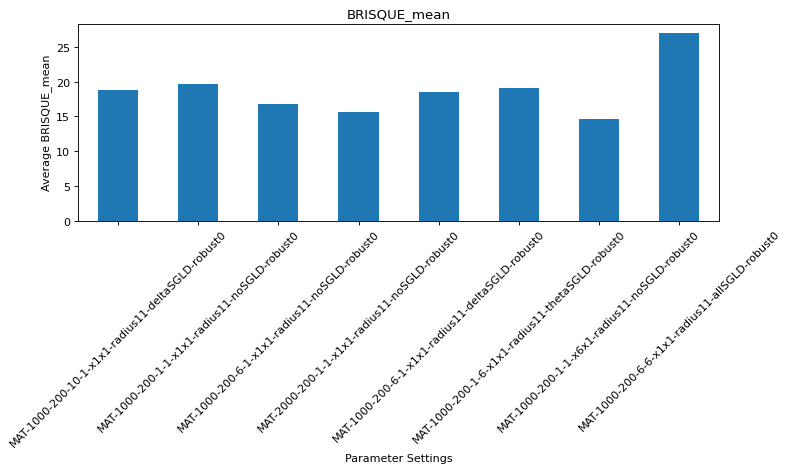

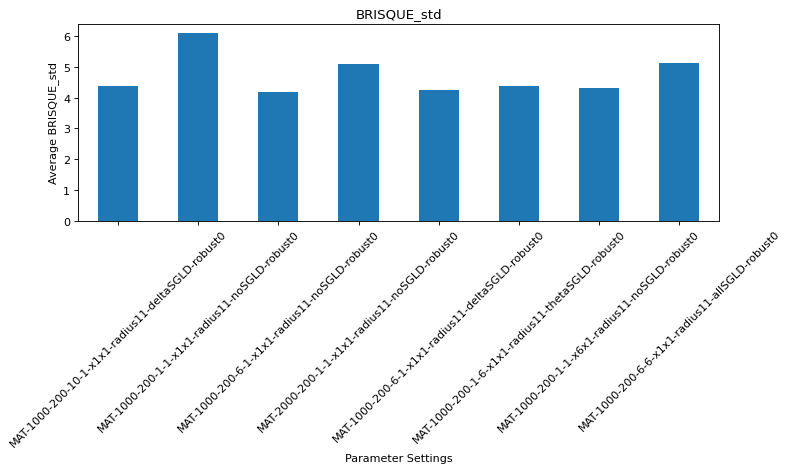

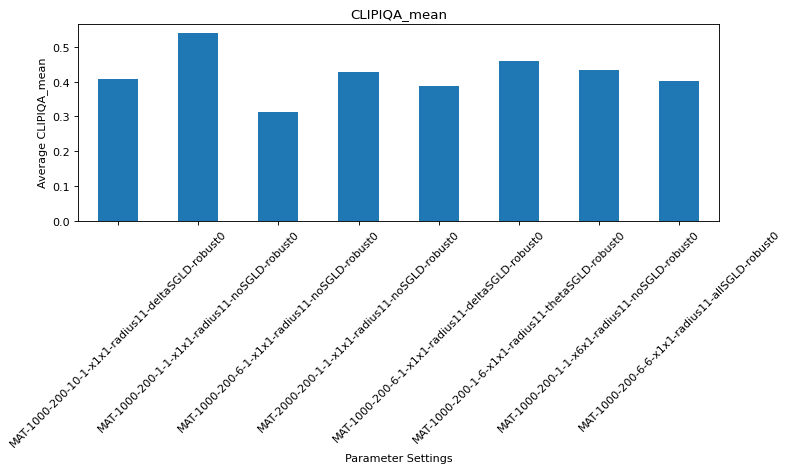

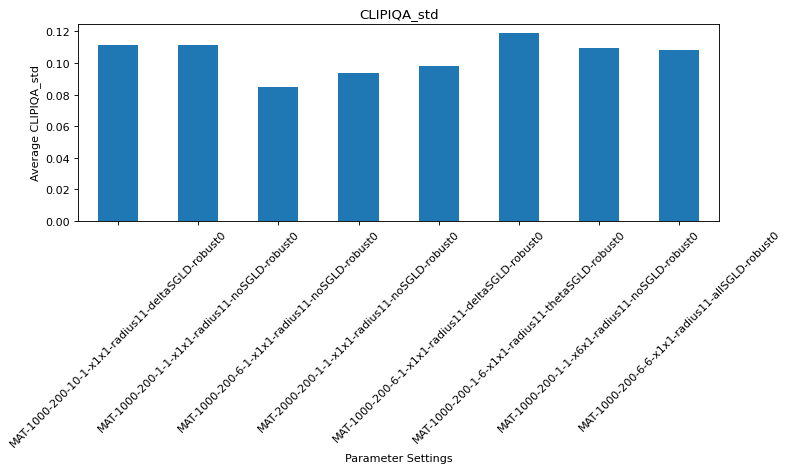

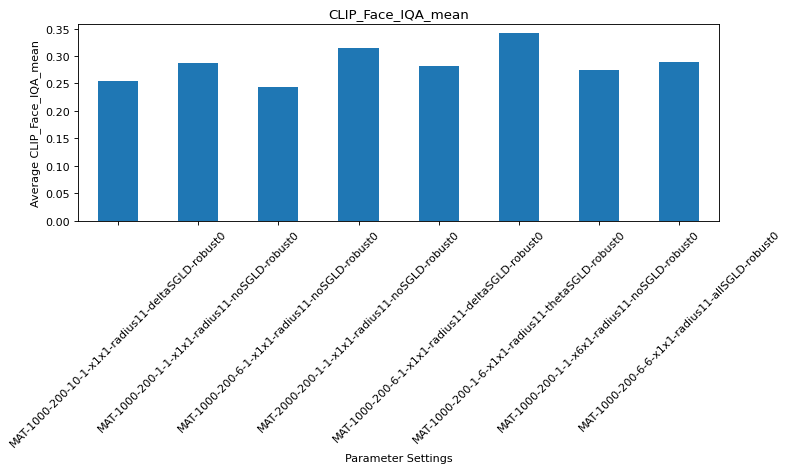

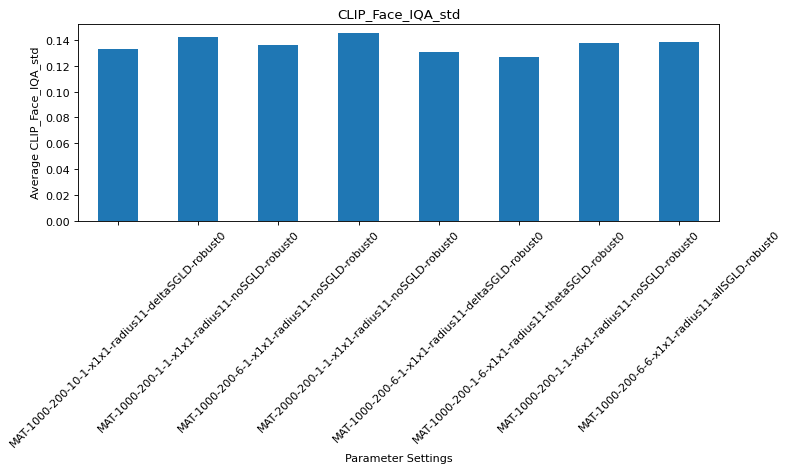

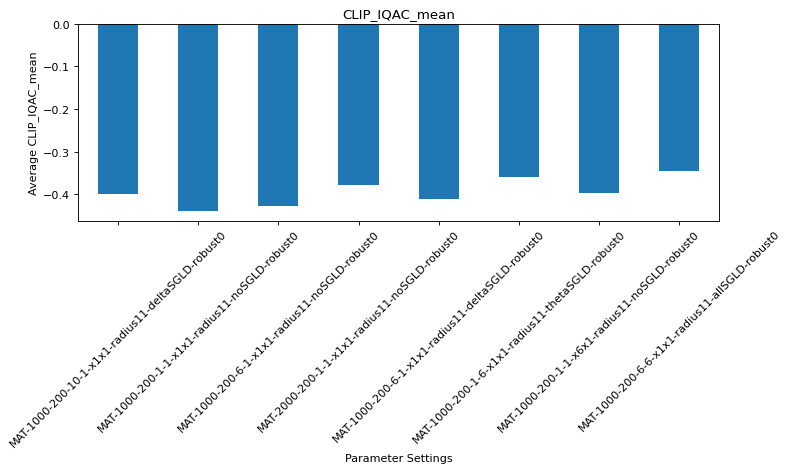

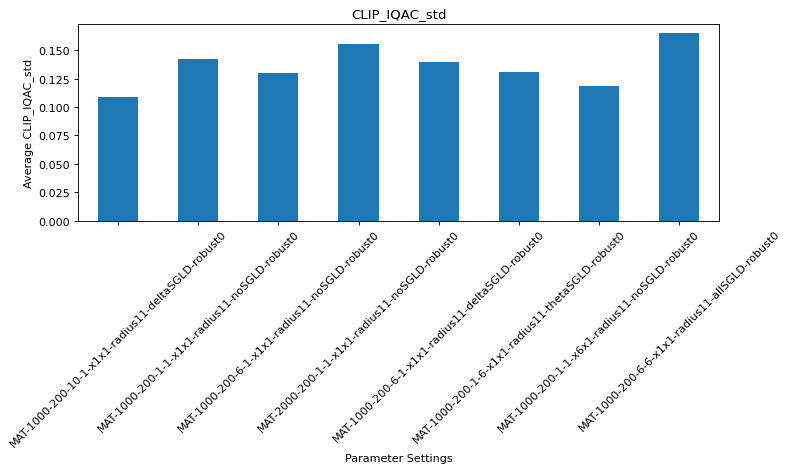

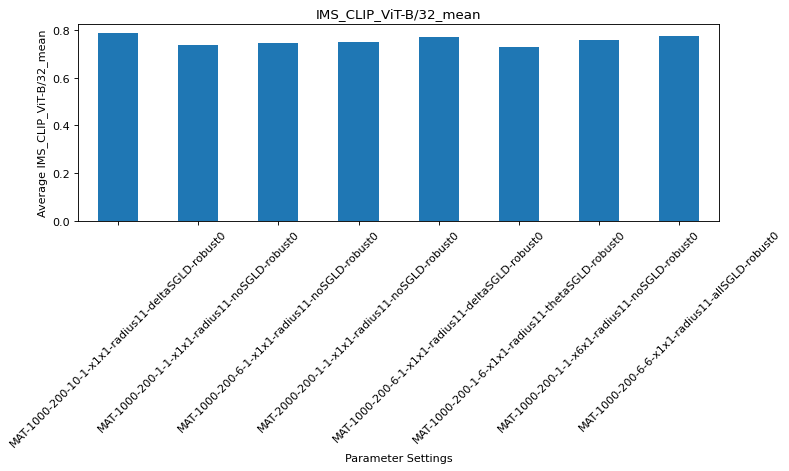

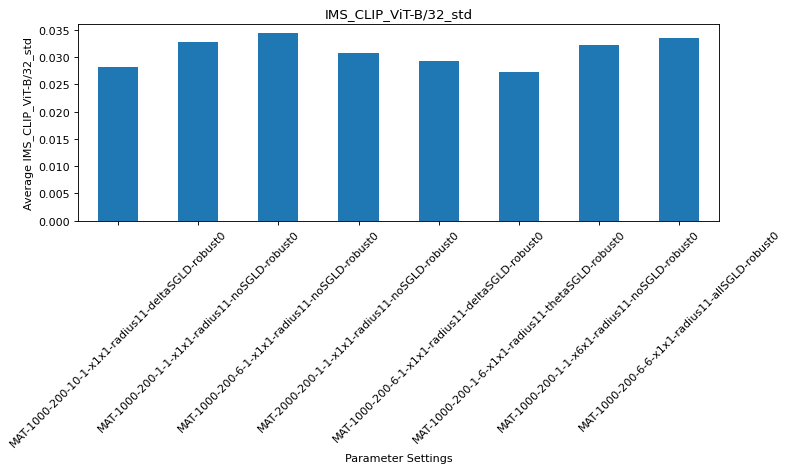

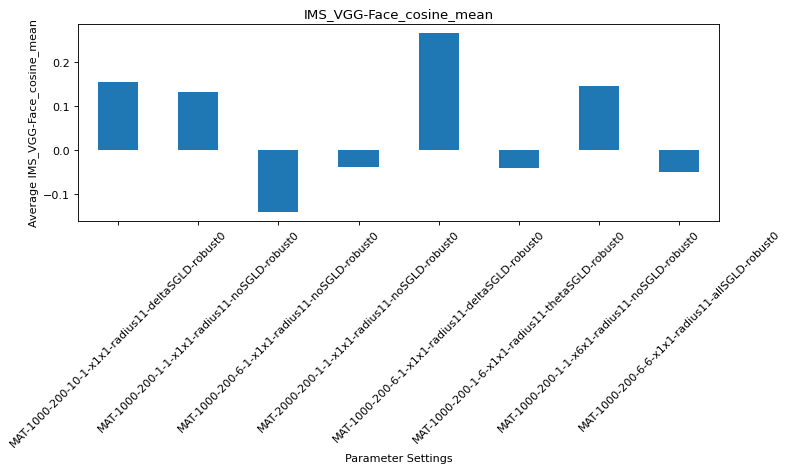

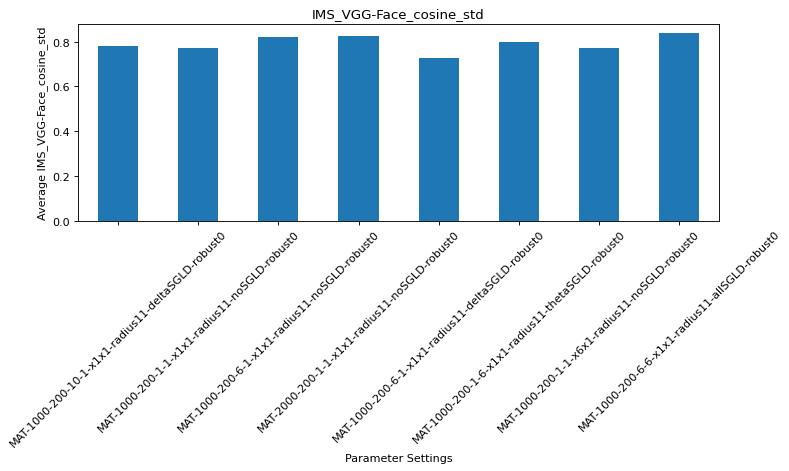

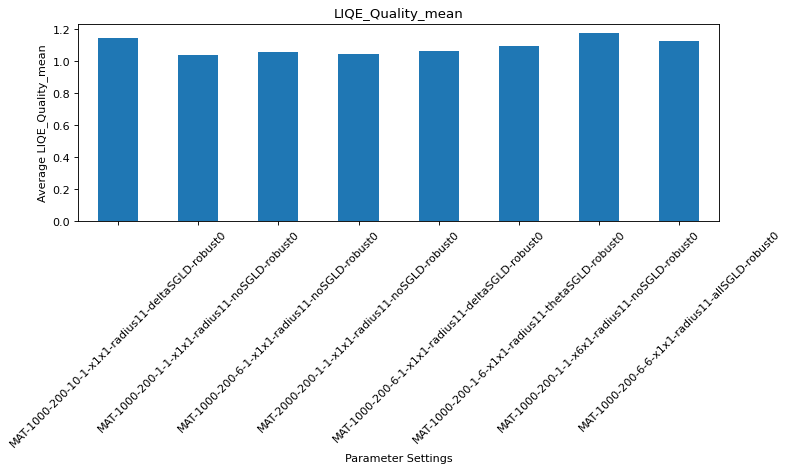

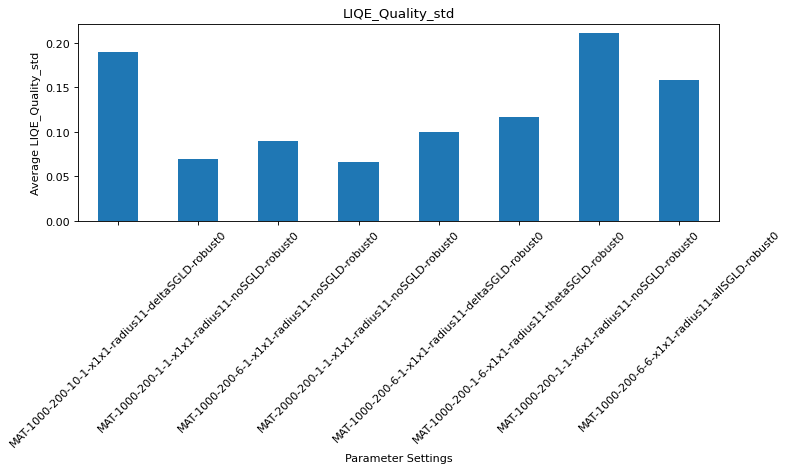

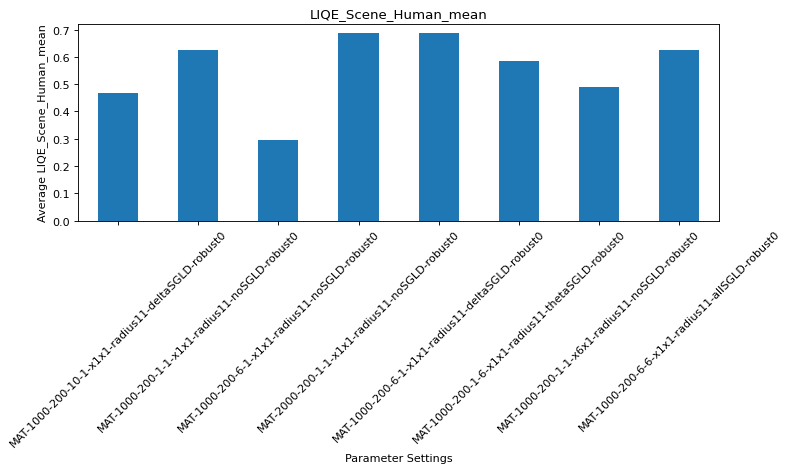

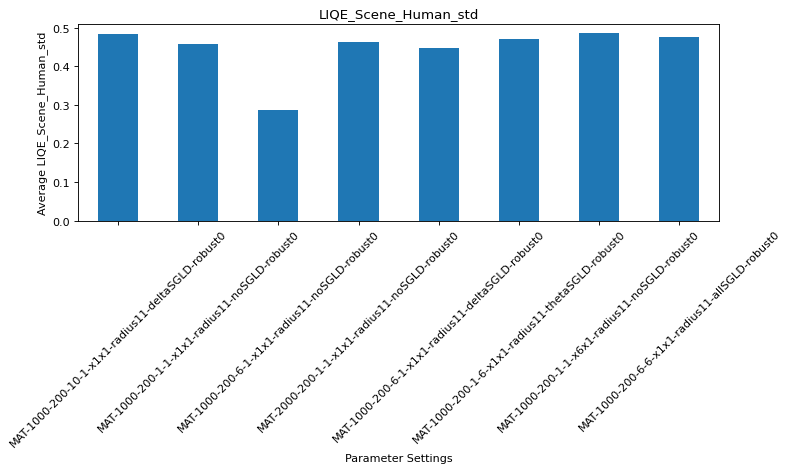

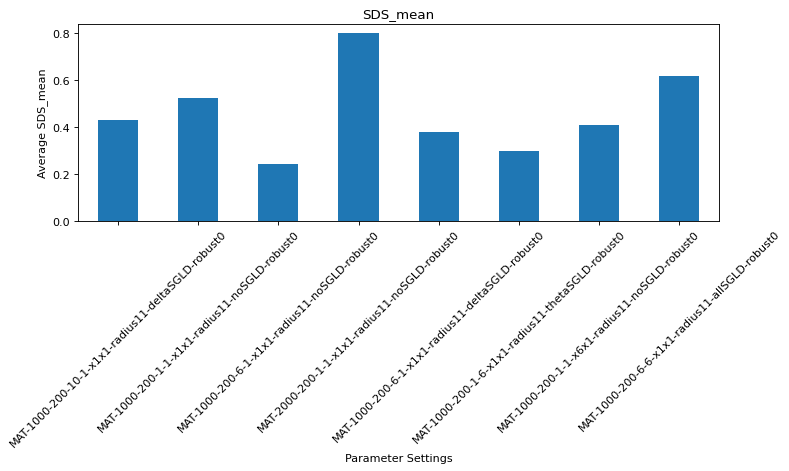

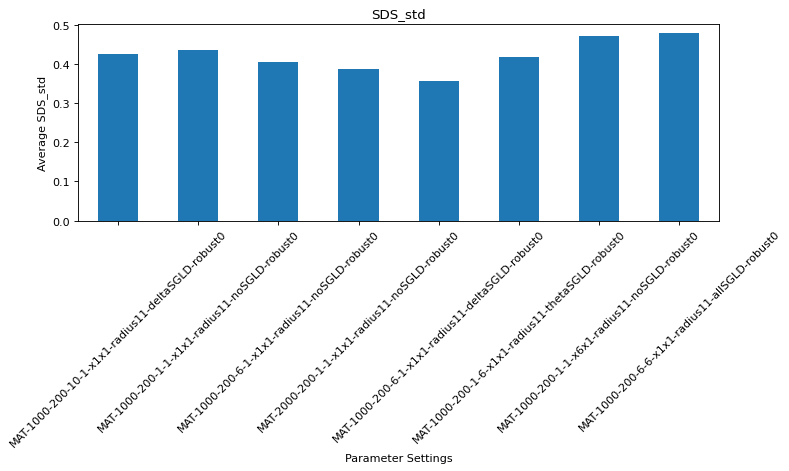

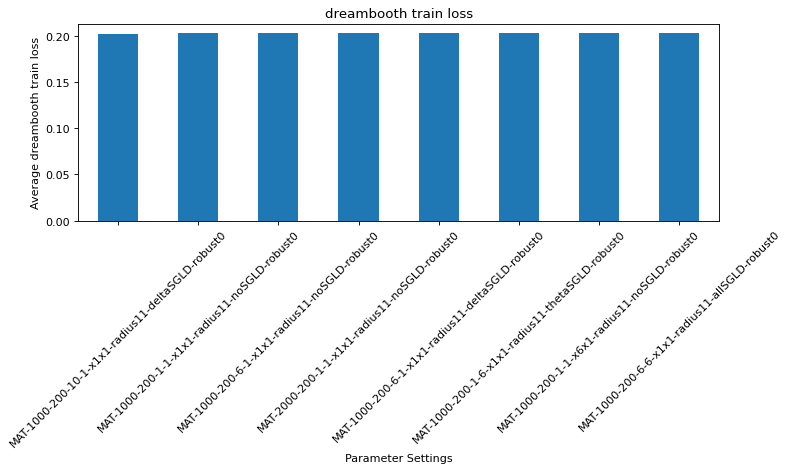

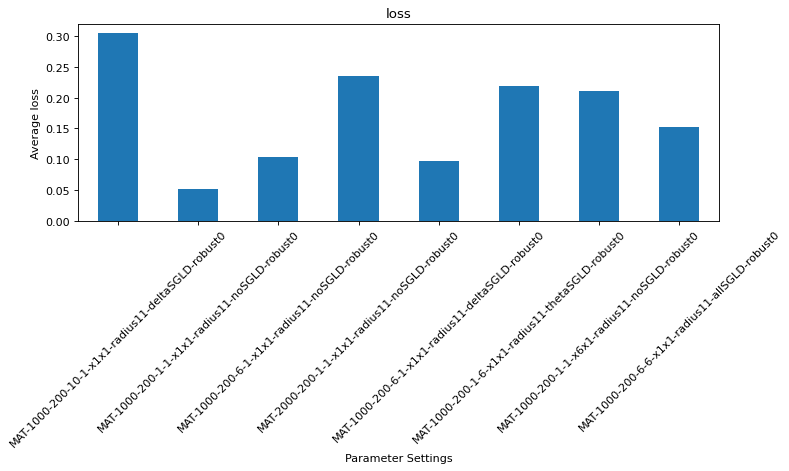

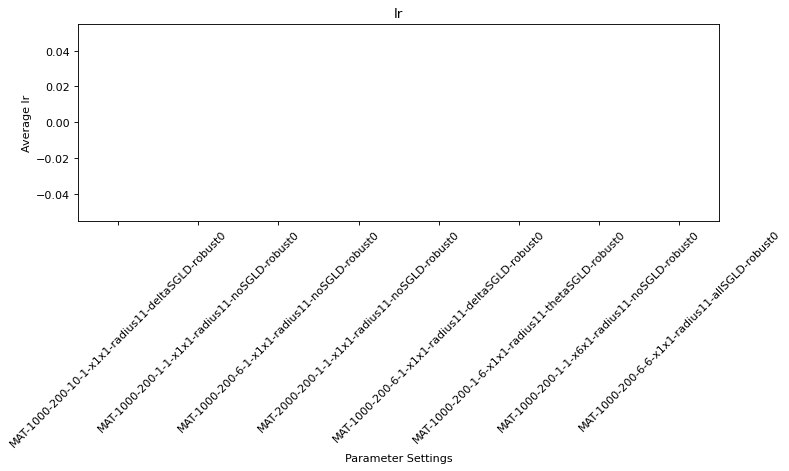

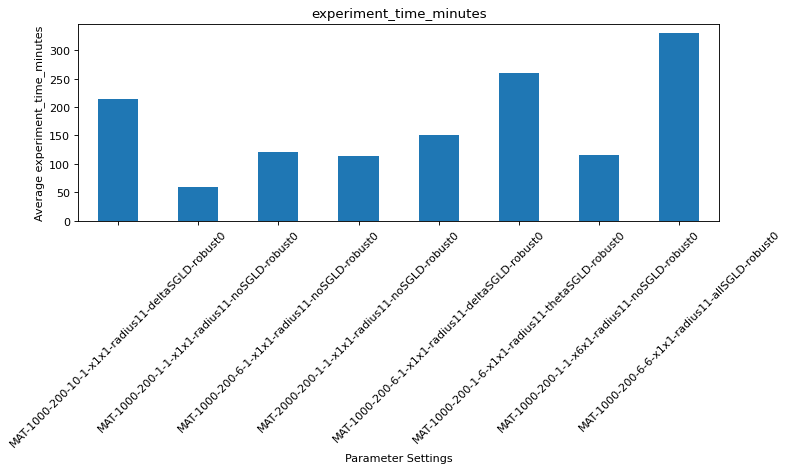

In [3]:
# 计算每组参数设置的平均值
avg_data = {}
for param_str, experiments in data.items():
    # 将同组实验结果转为DataFrame
    df = pd.DataFrame(experiments)
    
    # 去掉每列的最高值和最低值后计算平均值
    def trimmed_mean(series):
        sorted_series = series.sort_values()
        # 去掉一个最高和一个最低值
        trimmed_series = sorted_series[1:-1]
        return trimmed_series.mean()
    
    avg_data[param_str] = df.apply(trimmed_mean).to_dict()

# 将平均结果转换为DataFrame便于分析
avg_df = pd.DataFrame.from_dict(avg_data, orient='index')

# 针对每个指标分别绘制图表
for metric in metrics:
    plt.figure(figsize=(10, 6),dpi=80)
    avg_df[metric].plot(kind='bar')
    plt.title(f'{metric}')
    plt.xlabel('Parameter Settings')
    plt.ylabel(f'Average {metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<Figure size 8000x1600 with 0 Axes>

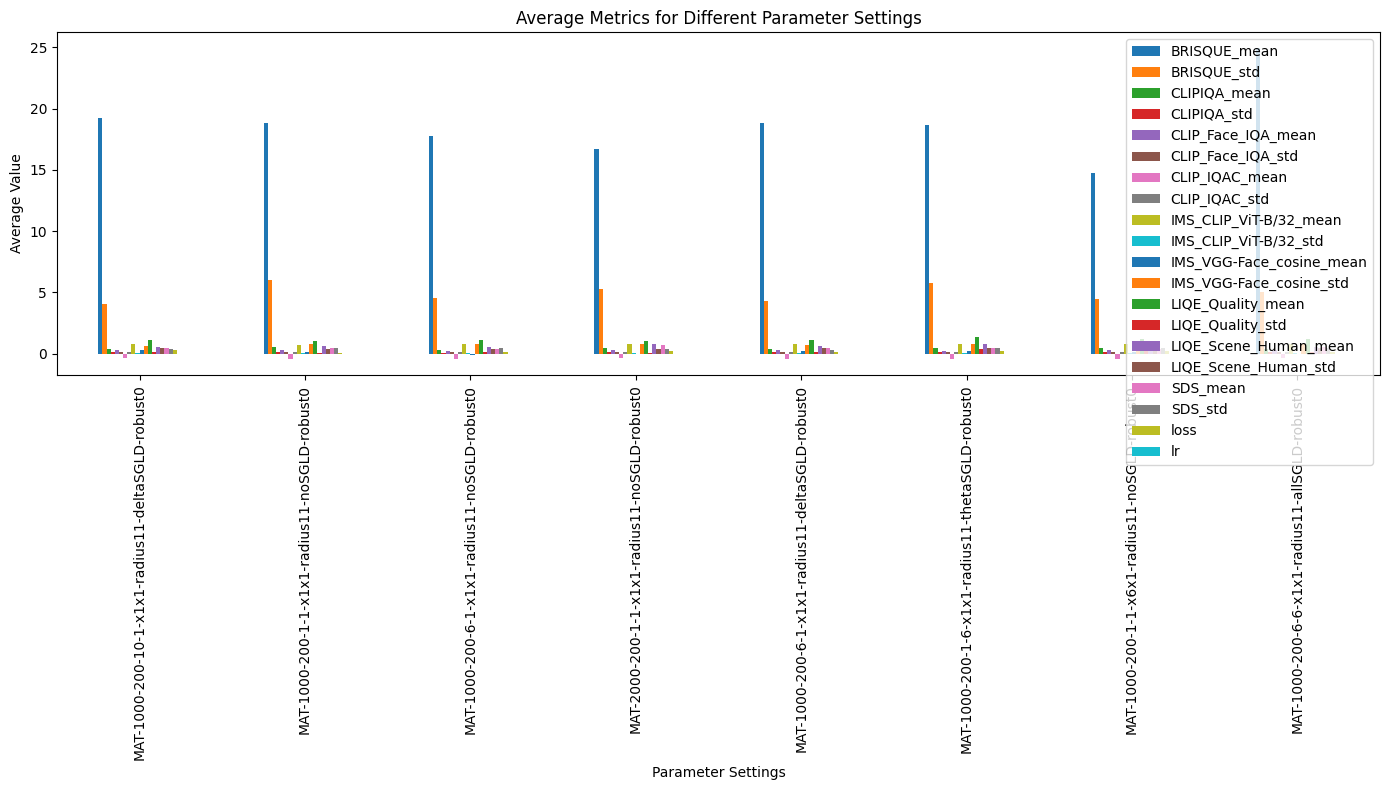

In [3]:
# 计算每组参数设置的平均值
avg_data = {}
for param_str, experiments in data.items():
    # 将同组实验结果转为DataFrame
    df = pd.DataFrame(experiments)
    avg_data[param_str] = df.mean().to_dict()

# 将平均结果转换为DataFrame便于分析
avg_df = pd.DataFrame.from_dict(avg_data, orient='index')

# 可视化平均指标
plt.figure(figsize=(100, 20),dpi=80)
avg_df.plot(kind='bar', figsize=(14, 8))
plt.title('Average Metrics for Different Parameter Settings')
plt.xlabel('Parameter Settings')
plt.ylabel('Average Value')
plt.legend(loc='best')
plt.tight_layout()
plt.show()